# L2HMC Sensitivity to NN Width
This notebook explores how changing the hidden layer width of the dynamics-controlling neural networks affects the efficiency of the l2hmc algorithm

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.append('/content/drive/MyDrive/repos/l2hmc')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jun  2 03:14:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

TensorFlow 1.x selected.


In [ ]:
from utils.func_utils import accept, jacobian, autocovariance, get_log_likelihood, \
    get_data, binarize, normal_kl, acl_spectrum, ESS
from utils.distributions import Gaussian, GMM, GaussianFunnel, gen_ring
from utils.layers import Linear, Sequential, Zip, Parallel, ScaleTanh
from utils.dynamics import Dynamics
from utils.sampler import propose
from utils.notebook_utils import get_hmc_samples

## Network architecture

We define the network architecture for our L2HMC network. We first embed the first two variables ($\{x, \partial_x U\}$ or $\{v, x_m\}$) as well as the time, formatted as $\tau(t) = \left(\cos(\frac{2\pi t}{M}), \sin(\frac{2\pi t}{M})\right)$. They are forwarded through an MLP and then produce $S, T$ and $Q$.

In [ ]:
def network(x_dim, width, scope, factor):
    with tf.variable_scope(scope):
        net = Sequential([
            Zip([
                Linear(x_dim, width, scope='embed_1', factor=1.0 / 3),
                Linear(x_dim, width, scope='embed_2', factor=factor * 1.0 / 3),
                Linear(2, width, scope='embed_3', factor=1.0 / 3),
                lambda _: 0.,
            ]),
            sum,
            tf.nn.relu,
            Linear(width, width, scope='linear_1'),
            tf.nn.relu,
            Parallel([
                Sequential([
                    Linear(width, x_dim, scope='linear_s', factor=0.001), 
                    ScaleTanh(x_dim, scope='scale_s')
                ]),
                Linear(width, x_dim, scope='linear_t', factor=0.001),
                Sequential([
                    Linear(width, x_dim, scope='linear_f', factor=0.001),
                    ScaleTanh(x_dim, scope='scale_f'),
                ])
            ])  
        ])
        
    return net

## Distribution

We define our energy function. It is a Gaussian distribution with zero mean. The covariance is a $\pi/4$ rotation of the eigenvalues $[100, 10^{-1}]$. We set up our dynamics which take as input our energy function, the number of time step of our operator, the (learnable) step-size and our architecture.

In [ ]:
x_dim = 2
network_width = 5
degree_rotation = 30
num_rotations = 5

mu = np.zeros(2,)
cov = np.array([[50.05, -49.95], [-49.95, 50.05]])
theta = np.radians(degree_rotation)
R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

distributions = []
for i in range(num_rotations):
  distributions.append(Gaussian(mu, cov))
  cov = R@cov@R.T

# dynamics = Dynamics(x_dim, distribution.get_energy_function(), T=10, eps=0.1, width=network_width, net_factory=network)

NotImplementedError: ignored

We can directly sample from this distribution and plot it for sanity-check.

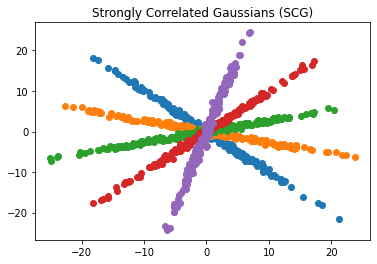

In [ ]:
S1 = distributions[0].get_samples(200)
S2 = distributions[1].get_samples(200)
S3 = distributions[2].get_samples(200)
S4 = distributions[3].get_samples(200)
S5 = distributions[4].get_samples(200)
plt.title('Strongly Correlated Gaussians (SCG)')
plt.scatter(S1[:, 0], S1[:, 1])
plt.scatter(S2[:, 0], S2[:, 1])
plt.scatter(S3[:, 0], S3[:, 1])
plt.scatter(S4[:, 0], S4[:, 1])
plt.scatter(S5[:, 0], S5[:, 1])
plt.show()

We set up the loss on both $p(\xi)$ (here `x`) and $q(\xi)$ (here `z`). We then train with Adam with a learning rate of $10^{-3}$.

In [ ]:
x = tf.placeholder(tf.float32, shape=(None, x_dim))
z = tf.random_normal(tf.shape(x))

Lx, _, px, output = propose(x, dynamics, do_mh_step=True)
Lz, _, pz, _ = propose(z, dynamics, do_mh_step=False)

loss = 0.

v1 = (tf.reduce_sum(tf.square(x - Lx), axis=1) * px) + 1e-4
v2 = (tf.reduce_sum(tf.square(z - Lz), axis=1) * pz) + 1e-4
scale = 0.1

loss += scale * (tf.reduce_mean(1.0 / v1) + tf.reduce_mean(1.0 / v2))
loss += (- tf.reduce_mean(v1) - tf.reduce_mean(v2)) / scale
print(loss)

Tensor("add_41:0", shape=(), dtype=float32)


In [ ]:
print(dynamics.temperature)

Tensor("Placeholder:0", shape=(), dtype=float32)


In [ ]:
global_step = tf.Variable(0., name='global_step', trainable=False)
learning_rate = tf.train.exponential_decay(1e-3, global_step, 1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss, global_step=global_step)

The training loop described in Algorithm $1$.

In [ ]:
n_steps = 2500
n_samples = 200

loss_hist = []
acceptance_hist = []

samples = np.random.randn(n_samples, x_dim)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

start_time = time.time()
for t in range(n_steps):
    _, loss_, samples, px_, lr_ = sess.run([
        train_op,
        loss,
        output[0],
        px,
        learning_rate,
    ], {x: samples})

    if t % 100 == 0:
        print('Step: %d / %d, Loss: %.2e, Acceptance sample: %.2f, LR: %.5f' % (t, n_steps, loss_, np.mean(px_), lr_))
        loss_hist.append(loss_)
        acceptance_hist.append(np.mean(px_))

training_time = time.time() - start_time

Step: 0 / 2500, Loss: -4.98e+01, Acceptance sample: 0.90, LR: 0.00100
Step: 100 / 2500, Loss: -1.55e+02, Acceptance sample: 0.76, LR: 0.00100
Step: 200 / 2500, Loss: -2.93e+02, Acceptance sample: 0.60, LR: 0.00100
Step: 300 / 2500, Loss: -3.51e+02, Acceptance sample: 0.49, LR: 0.00100
Step: 400 / 2500, Loss: -1.05e+03, Acceptance sample: 0.31, LR: 0.00100
Step: 500 / 2500, Loss: -2.22e+03, Acceptance sample: 0.23, LR: 0.00100
Step: 600 / 2500, Loss: -2.33e+03, Acceptance sample: 0.22, LR: 0.00100
Step: 700 / 2500, Loss: -3.05e+03, Acceptance sample: 0.24, LR: 0.00100
Step: 800 / 2500, Loss: -3.03e+03, Acceptance sample: 0.23, LR: 0.00100
Step: 900 / 2500, Loss: -2.94e+03, Acceptance sample: 0.24, LR: 0.00100
Step: 1000 / 2500, Loss: -3.48e+03, Acceptance sample: 0.27, LR: 0.00096
Step: 1100 / 2500, Loss: -3.23e+03, Acceptance sample: 0.25, LR: 0.00096
Step: 1200 / 2500, Loss: -3.25e+03, Acceptance sample: 0.31, LR: 0.00096
Step: 1300 / 2500, Loss: -3.03e+03, Acceptance sample: 0.28, LR

After training, we generate $200$ chains for $2000$ steps for evaluation purposes.

In [ ]:
samples = distribution.get_samples(n=n_samples)
final_samples = []

start_time = time.time()
for t in range(2000):
    final_samples.append(np.copy(samples))

    feed_dict = {
        x: samples,
    }

    samples = sess.run(output[0], feed_dict)
sample_time = time.time() - start_time

Saving data from this run for later comparison:

In [ ]:
L2HMC_samples = np.array(final_samples)
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)

l2hmc_data={"problem_type": "SCG",
            "network_type": "5 unit width",
            "training_time": training_time,
            "loss": loss_hist,
            "acceptance": acceptance_hist,
            "samples": L2HMC_samples,
            "sample_time": sample_time,
            "acl": L2HMC,
            "ess": ESS(L2HMC)
            }

np.save("/content/drive/MyDrive/repos/l2hmc/data/width5.npy", l2hmc_data)

In [ ]:
print(l2hmc_data["samples"].shape)

(2000, 200, 2)


We compute the HMC chains with **auto-correlation spectrums** as well.

In [ ]:
L2HMC_samples = np.array(final_samples)
HMC_samples_1 = get_hmc_samples(2, 0.1, distribution.get_energy_function(), sess, steps=2000, samples=samples)
HMC_samples_2 = get_hmc_samples(2, 0.15, distribution.get_energy_function(), sess, steps=2000, samples=samples)
HMC_samples_3 = get_hmc_samples(2, 0.2, distribution.get_energy_function(), sess, steps=2000, samples=samples)

In [ ]:
scale = np.sqrt(np.trace(cov))
L2HMC = acl_spectrum(L2HMC_samples, scale=scale)
HMC1 = acl_spectrum(HMC_samples_1, scale=scale)
HMC2 = acl_spectrum(HMC_samples_2, scale=scale)
HMC3 = acl_spectrum(HMC_samples_3, scale=scale)

We can plot auto-correlation.

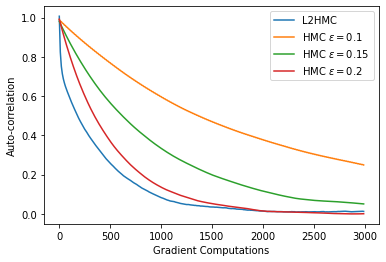

In [ ]:
xaxis = 10 * np.arange(300)
plt.plot(xaxis, L2HMC[:300], label='L2HMC')
plt.plot(xaxis, HMC1[:300], label='HMC $\epsilon=0.1$')
plt.plot(xaxis, HMC2[:300], label='HMC $\epsilon=0.15$')
plt.plot(xaxis, HMC3[:300], label='HMC $\epsilon=0.2$')
plt.ylabel('Auto-correlation')
plt.xlabel('Gradient Computations')
plt.legend()
plt.show()

We now compute the **Effective Sample Size** (ESS).

In [ ]:
print('ESS L2HMC: %.2e -- ESS HMC: %.2e -- Ratio: %d' % (ESS(L2HMC), ESS(HMC2), ESS(L2HMC) / ESS(HMC2)))

ESS L2HMC: 1.48e-02 -- ESS HMC: 5.70e-03 -- Ratio: 2


We can visualize a single chain of L2HMC for $50$ time steps.

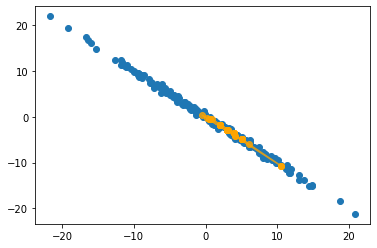

In [ ]:
plt.scatter(S[:, 0], S[:, 1])
plt.plot(L2HMC_samples[:50, 1, 0], L2HMC_samples[:50, 1, 1], color='orange', marker='o', alpha=0.8)
plt.show()